# Lending Club Loan Data Analysis and Predictive Modeling

## Summary

We approach this analysis from a perspective of an accredited or institutional investors, whose interests are maximizing risk-adjusted returns. Exploratory data analysis reveals that the market is growing at a healthy clip which is a positive factor for these investors who have liquidity needs. We also see that at an individual security level, these loans are highly volatile- making it a bad risk-adjusted investment without proper diversification. Constructing a portfolio of loans showed that an investor can effectively diversify out the risk from the default rate.

We then explore how we can generate alpha in our loan seletion criteria. We split our data into training and test sets, and build a prediction model, a simple approach using linear regression. Collecting top 1000 from our model's prediction in a test set dramatically outperformed 1000 randomly selected loans by as much as 5.6% in IRR. This was a suprising result given our R2 of the model was very low. However, that is understandable since return distribution in this asset class is very polarized. Any modeling that yields a point estimate is going to perform badly on paper since the real data will either overshoot(fully paid) or undershoot(default) but when you spread out the defaut rate, on average, our model fared well in extracting useful information out of the features.

We acknowledge that our model can have a look ahead bias, training our model using data that we would other wise not have at the time. I recommend considering a buy-hold-sell strategy leveraging the marketplace. This way, we can use data for example, 6 months and older to build a model for 6 month holding strategy. I also recommend exploring more rigorous forecasting methods,d improving the code so it can scale better with growing market data and implementing unit testing.

## Data Cleaning & Environment Set Up

### Packages & Data Loading

In [208]:
###Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML
import datetime
import math
import scipy.optimize as optimize
import statistics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import scipy
import warnings
from scipy.stats import norm
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [ ]:
### data loading 
df = pd.read_csv('./data/loan.csv', low_memory=False)

### Data Processing & Manipulation

In [ ]:
###changing data type to appropriate date type 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [ ]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatment
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [ ]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month
df['mo_diff'] = pd.to_numeric((df['last_pymnt_yr'] - 
                          df['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])

In [ ]:
###Flag for completed loans
searchfor = ['Fully Paid', 'Charged Off', 'Default']
defaults = ['Charged Off', 'Default']
df['loan_completion_flag']=  np.where(df['loan_status'].str.contains('|'.join(searchfor)) ,1, np.nan)
###Flag for fully paid loans
df['fully_paid'] = np.where(df['loan_status'].str.contains('Fully Paid') ,1, 
                                  np.where(df['loan_status'].str.contains('|'.join(defaults)) ,0,np.nan))


In [ ]:
###Example output of above manipulation
df.head()[['loan_status','loan_completion_flag','fully_paid']]

## Exploratory Data Analysis

### Calculations & Assumptions

We calculate the return of a loan by looking at the IRR of its cash flows. We make an assumption that (total payment - recoveries - last payment) are spread evenly across the life of the loan(last payment - issue date) -1 month. We net out the last payment to account for edge cases such as when a lender prepays with a big lump sum. We should not be discounting these cash flows earlier than they occur. 

For most loans, this treatment is almost identical to installment payments. We then add back in the last payment amount. For recoveries, we make an assumption that it will take on average rest of the maturity of the loan + 1 year to recover. So any recovery and recovery collection fees are spread across the remaining duration of 36 month life of the loan plus additional 12 months. We give heavier penalties to loans that default earlier essentially. We, then calculate the IRR of these series of cashflows. 

Ideally, we can pin point exactly when each payment is made, but this is not an option we have with our data. So we leverage any information that we can use to get to a close of an approximation as possible. 

In [ ]:
###Average payment = Total payment - recoveries - last payment amount over the life -1 month of the investment
df['avg_pymnt'] = (df['total_pymnt']-df['recoveries']-df['last_pymnt_amnt'])/(np.maximum((df['mo_diff']-1),0))
###Treating infinites that appear when there is no payment or only 1 payment 
df['avg_pymnt'] = (df['avg_pymnt']).replace(np.Inf,0)
df['avg_pymnt'] = (df['avg_pymnt']).replace(-np.Inf,0)

In [ ]:
###IRR calculations
###Input: a row of a dataframe with lending data 
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = np.max(int(x['mo_diff'])-1,0)
    recovery = x['recoveries'] -x['collection_recovery_fee']
    recovery_duration = np.maximum(36 - num_payments + 1 + 12,12)
    avg_recovery = recovery/recovery_duration
    last_payment_amount = x['last_pymnt_amnt']
    ###IRR calculation, input: series of cash flows, total payment - recoveries
    ###evenly divided and spread across the life of the loan and finally recovery and chargeoff fees
    return ((np.irr([initial_invest]+[avg_payment]*num_payments + [last_payment_amount] +
                    [avg_recovery]*recovery_duration)+1)**12-1)

In [ ]:
###Calculating at a row level, individual security IRRs. Method will be faulty for loans that didn't mature.
###Warning: the calculation takes a fair amount of time ~few minutes
df['irr']=df.apply(irr_calc, axis=1)

In [ ]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df['irr']=df['irr'].replace(np.NaN,-1)

### Summary Statistics on Overall Market by Year

In [53]:
df_group = df.groupby(['issue_yr'])
#df_group.describe(percentiles=[])[['mo_diff','loan_amnt','loan_status_flag','irr','int_rate']].loc[['count','max']]
df_group.agg([np.mean, len, statistics.median, np.std])[['mo_diff','funded_amnt','fully_paid','irr','int_rate']].transpose()

issue_yr                   2007         2008         2009          2010  \
mo_diff     mean      26.308458    26.661931    26.246355     29.661243   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median    33.000000    32.000000    31.000000     32.000000   
            std       11.727996    11.520294    11.445312     14.648194   
funded_amnt mean    7946.185738  8347.273297  9811.541375  10078.262343   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median  6000.000000  7000.000000  8650.000000   9000.000000   
            std     5897.897343  5556.902423  5987.161795   6186.399743   
fully_paid  mean       0.737977     0.792729     0.863094      0.859938   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median     1.000000     1.000000     1.000000      1.000000   
            std        0.440100     0.405436     0.343781      0.347065   
irr         mean      -0.031609    -0.003648     0.049158      0.049033   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median     0.107518     0.114199     0.125278      0.112849   
            std        0.303864     0.296726     0.244018      0.225909   
int_rate    mean      11.825108    12.061964    12.437247     11.985268   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median    11.540000    11.910000    12.530000     11.860000   
            std        2.730695     2.528280     2.670839      3.487358   

issue_yr                    2011          2012           2013           2014  \
mo_diff     mean       29.182174     26.310135      22.436258      15.473382   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median     32.000000     29.000000      25.000000      16.000000   
            std        14.103763     11.360228       8.804633       5.069411   
funded_amnt mean    11848.609640  13452.932055   14708.051649   14870.177462   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median  10000.000000  12000.000000   13000.000000   13000.000000   
            std      7895.098134   8078.326704    8099.065957    8438.330135   
fully_paid  mean        0.836763      0.836422       0.789705       0.789430   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median      1.000000      1.000000       0.000000            NaN   
            std         0.369591      0.369896       0.407521       0.407717   
irr         mean        0.040954      0.049310      -0.028577      -0.382607   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median      0.105541      0.119900       0.048285      -0.465180   
            std         0.227265      0.225935       0.229724       0.339233   
int_rate    mean       12.223746     13.637676      14.531745      13.771245   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median     11.990000     13.670000      14.330000      13.650000   
            std         4.148980      4.371890       4.437612       4.325532   

issue_yr                     2015  
mo_diff     mean         5.513693  
            len     421094.000000  
            median       5.000000  
            std          3.435963  
funded_amnt mean     15240.255561  
            len     421094.000000  
            median   14000.000000  
            std       8571.313525  
fully_paid  mean         0.879131  
            len     421094.000000  
            median            NaN  
            std          0.325981  
irr         mean        -0.904201  
            len     421094.000000  
            median      -0.996545  
            std          0.261512  
int_rate    mean        12.601731  
            len     421094.000000  
            median      12.290000  
            std        

Few things to note here:
    1. Market is growing(number of loans and loan size) at a healthy clip - this is a good thing for institutional investors with liquidity needs.
    2. Standard Deviation of the IRRs are huge, likely due to defaults. Any serious investors looking for good risk/reward trade-off should mitigate the risk by pooling lots of loans.
    3. 2007-2008 loans have unusually big negative returns accompanied with high default rates(1- fully_paid). This is likely due to market conditions, but there can be other reasons such as inefficient market and initial lack of credible borrowers. However, this may be a good indication that p2p lending maket is not recession proof.
    4. We see that recent IRRs are in the negatives because non-defaulting loans haven't matured yet. This limits our training dataset for buy and hold strategy to just loans that are 2012 and older. An interesting follow up would be to look at buy-hold-sell strategy leveraging the note trading platform. We can then incorporate much more recent data into our model.

In [ ]:
####Filter down to completed loans and has at least 36 months of possible history
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012").copy()

### Distribution of Matured Returns 

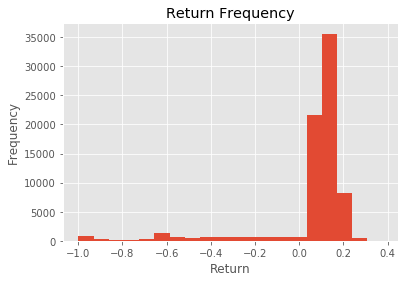

In [52]:
####Histogram of returns
plt.hist(df_filtered['irr'],bins=20) 
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Return Frequency')
plt.show()

There are few things to note here
    1. Lending returns are clearly not normally distributed and very long tailed skewed to the left. 
    2. That means extreme losses are possible. Again, pooling loans to spread the default risk out is a key to a successful investment strategy.
    3. We have some unusually high return loans. These tend to be high interest and low grade loans that were prepaid very early. An example is shown below. I don't think there is a need to remove them since they are real loans, and our IRR calculation models their performance in a reasonable manner.

###### High Return Outlier Example

In [ ]:
df_filtered.loc[df_filtered.irr.argmax()][['loan_status','total_pymnt','loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                               ,'collection_recovery_fee','recoveries','total_rec_late_fee','grade']]

### Weighted Average IRR of all Completed Loans Originated from 2007-2012

In [54]:
###Weight the returns by funded amount to get more accurate representation
weighted_avg = np.average(df_filtered['irr'], weights=df_filtered['funded_amnt'])
weighted_avg

0.061408379614021645

it's important to note how the weighted average is higher than the raw averages. This is an indication that higher balance loans are better performing. We will investigate that next.

### Weighted Average IRR Bucketed by Size of the Loan 

In [ ]:
### we bucket by using 33% 66% and 100% tiles
bucket = df_filtered['funded_amnt']
np.percentile(bucket, [33, 66, 100])

In [58]:
df_filtered['size_bucket'] = np.where(df_filtered['funded_amnt']<=7000 ,'small',
                            np.where(df_filtered['funded_amnt']<=12000  ,'medium','large'))
df_group_size = df_filtered.groupby(['size_bucket','grade'])
# df_group_size.[np.mean, len, statistics.median, np.std]
df_group_size_irr = df_group_size.apply(lambda x: np.average(x['irr'],weights = x['funded_amnt']))

In [59]:
df_group_check = df_filtered.groupby(['grade','size_bucket'])
df_group_check.agg([np.mean, len, np.std])[['irr','int_rate','annual_inc','fully_paid']]

irr                     int_rate                    \
                       mean     len       std       mean     len       std   
grade size_bucket                                                            
A     large        0.048444  5018.0  0.141421   7.693300  5018.0  0.944082   
      medium       0.045590  6983.0  0.142148   7.373968  6983.0  1.024089   
      small        0.039728  8485.0  0.153291   7.427074  8485.0  1.038138   
B     large        0.065240  7869.0  0.194547  11.790403  7869.0  1.283790   
      medium       0.062350  9302.0  0.201307  11.819275  9302.0  1.278383   
      small        0.054472  9250.0  0.206924  11.544396  9250.0  1.292427   
C     large        0.074090  4875.0  0.231474  14.656297  4875.0  1.258865   
      medium       0.057088  5801.0  0.249715  14.616266  5801.0  1.292251   
      small        0.055164  5532.0  0.250642  14.294864  5532.0  1.404782   
D     large        0.074040  3503.0  0.274552  17.392241  3503.0  1.706903   
      medium       0.064777  2971.0  0.273546  17.004423  2971.0  1.657422   
      small        0.049571  2438.0  0.283230  16.180082  2438.0  1.813740   
E     large        0.087098  1042.0  0.282827  19.009012  1042.0  2.288736   
      medium       0.036175   442.0  0.321180  17.252534   442.0  2.313854   
      small        0.031156   607.0  0.307370  17.057166   607.0  2.463775   
F     large       -0.012374   259.0  0.380024  19.262201   259.0  2.514824   
      medium      -0.007534   122.0  0.373955  17.852213   122.0  2.395355   
      small        0.047882   135.0  0.333999  18.623852   135.0  2.549009   
G     large        0.012118   130.0  0.378527  20.321923   130.0  2.486990   
      medium      -0.156198    44.0  0.458387  18.752273    44.0  1.287225   
      small        0.068759    70.0  0.251827  18.714714    70.0  1.348149   

                      annual_inc                        fully_paid          \
                            mean     len            std       mean     len   
grade size_bucket                                                            
A     large         90602.383147  5018.0   58693.670374   0.940016  5018.0   
      medium        67438.238556  6983.0   45092.889777   0.939281  6983.0   
      small         57151.060843  8485.0   45434.296782   0.926930  8485.0   
B     large         84879.352174  7869.0   97530.479512   0.886517  7869.0   
      medium        61185.170974  9302.0   37316.415127   0.881316  9302.0   
      small         53153.282918  9250.0   37930.321834   0.874486  9250.0   
C     large         83812.823778  4875.0   91729.251178   0.847795  4875.0   
      medium        61514.939950  5801.0   44557.193883   0.821065  5801.0   
      small         53028.110618  5532.0   87079.283111   0.831345  5532.0   
D     large         88101.931296  3503.0   57781.109898   0.803311  3503.0   
      medium        61394.401619  2971.0   38013.600075   0.793672  2971.0   
      small         49065.504844  2438.0   30376.008786   0.789582  2438.0   
E     large         97323.698436  1042.0   53568.718930   0.792706  1042.0   
      medium        67983.985475   442.0   46817.154945   0.766968   442.0   
      small         49151.076837   607.0   35402.053167   0.754530   607.0   
F     large        107366.553900   259.0  105567.721921   0.671815   259.0   
      medium        67427.292377   122.0   41441.769855   0.713115   122.0   
      small         49296.934000   135.0   34537.647878   0.777778   135.0   
G     large        123393.868923   130.0   95726.491461   0.684615   130.0   
      medium        72324.968182    44.0   40897.392318   0.545455    44.0   
      small         53447.454286    70.0   34845.694532   0.685714    70.0   

                             
                        std  
grade size_bucket            
A     large        0.237481  
      medium       0.238831  
      small        0.260267  
B     large        0.317203  
      medium       0.323434  
      small        0.331318  
C     la

We can conclude few things

    1. Larger loans perform better across all higher grade asset classes.
    2. While there is no clear correlation between interest rates and larger loans, there is a strong correlation with average income and default rate. This is an indication that people wth higher income are more likely to be good borrowers.  
    3. Higher annual income and size of the loan should be good predictors of low default rates and therefore higher IRR.

### Weighted Average of IRRs Bucketed by Year and Grade

In [60]:
df_group_grade = df_filtered.groupby(['issue_yr','grade'])
df_group_irr = df_group_grade.apply(lambda x: np.average(x['irr'],weights = x['funded_amnt']))
df_group_irr.argmax()

(2012, 'G')

G Grade in 2012 were the most profitable in terms of returns. Next in line were grade E loans in 2011.

In [64]:
df_group_irr

issue_yr  grade
2007      A        0.079712
          B       -0.011396
          C       -0.019417
          D       -0.067096
          E       -0.084850
          F       -0.199889
          G       -0.139833
2008      A        0.055883
          B       -0.004535
          C       -0.030417
          D       -0.071440
          E       -0.000634
          F       -0.132702
          G       -0.086513
2009      A        0.053644
          B        0.043685
          C        0.045890
          D        0.048454
          E        0.032890
          F       -0.000887
          G        0.046063
2010      A        0.054654
          B        0.065036
          C        0.068223
          D        0.063619
          E        0.063012
          F       -0.023619
          G        0.030864
2011      A        0.044842
          B        0.067759
          C        0.065826
          D        0.087835
          E        0.110945
          F        0.072805
          G       -0.079724
2012

Except in 2009, there is a general trend of lower grade loans performing better than the higher grade loans. However, we will later dispute this claim in our modeling section.

### Distribution of Returns of Pool of Loans 

So far we just looked at the distribution of returns. However, to measure risk-adjusted returns, we can look at the distribution of holding a pool of loans. With this methodology, we can ask questions such as had we held 100 loans over the duration of its maturity, what would the distribution of those returns would have looked like, and finding the x% confidence interval of those returns.

In [ ]:
def cash_flow(row,max_n):
    initial_invest = -row['funded_amnt']
    avg_payment = row['avg_pymnt']
    num_payments = np.max(int(row['mo_diff'])-1,0)
    recovery = row['recoveries'] -row['collection_recovery_fee']
    recovery_duration = np.maximum(36 - num_payments + 1 + 12,12)
    avg_recovery = recovery/recovery_duration
    last_payment_amount = row['last_pymnt_amnt']
    dummy_cfs = int(max_n -(1+num_payments+recovery_duration))
    return [initial_invest]+[avg_payment]*num_payments+[last_payment_amount]+[avg_recovery]*recovery_duration+ [0]*dummy_cfs

In [ ]:
def irr_pool(df):
    list_length = df['mo_diff'].max()+12
    cfs=[]
    for index, row in df.iterrows(): 
        cfs.append(cash_flow(row,list_length))
    result = [sum(x) for x in zip(*cfs)]
    return (np.irr(result)+1)**12 -1

In [ ]:
def collect_n_random_stats(df,n,size):
    returns_list = []
    for x in range(0,n):
        df_out = df.sample(size,replace=False)
        returns_list.append(irr_pool(df_out))   
    return [np.average(returns_list)] +[math.sqrt(np.var(returns_list))]

In [ ]:
####Collect 100 samples of 100 loans(~1M in exposure)
out=collect_n_random_stats(df_filtered,100,100)
out

Risk-adjusted return of 100 loan(~1M in exposure) samples.
It should be acknowledged that risk-adjusted returns are probably a big function of time,
and our method randomizes across time but there are smaller number of earlier loans. So this approach will be biased towards favoring the recent data.

In [65]:
out[0]/out[1]

3.3249664913967347

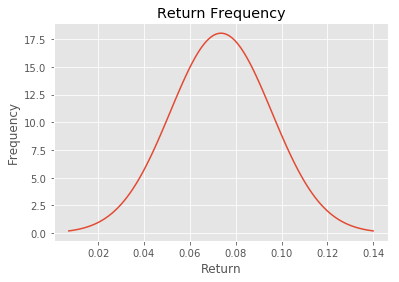

In [66]:
mu = out[0]
sigma = out[1]
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Return Frequency')
plt.show()

To account for the time variable, we should see how the risk-adjusted returns have changed over the years

In [67]:
##### See how the risk-adjusted returns have changed over the years
cust = lambda g: collect_n_random_stats
df_group = df_filtered.groupby(['issue_yr'])
df_group.count()
df_sharpe =df_group.apply(lambda x: collect_n_random_stats(x,100,100))
#df_group_irr = df_group.apply(lambda x:collect_n_random_stats(x,10,np.min(1000, x.count().loc[0]/10)))

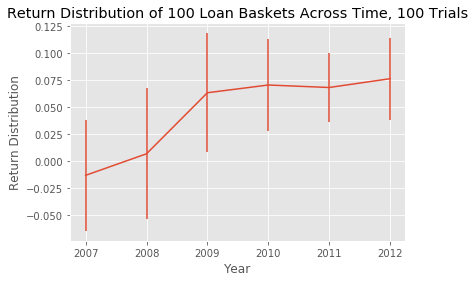

In [245]:
x = df_sharpe.index
y = [sublist[0] for sublist in df_sharpe.values]
yerr = [sublist[1]*2 for sublist in df_sharpe.values]
fig, ax = plt.subplots()
ax.errorbar(x, y,  yerr=yerr)
plt.xlabel('Year')
plt.ylabel('Return Distribution')
plt.title('Return Distribution of 100 Loan Baskets Across Time, 100 Trials')
plt.show()

This thought exercise tells us a few things
    1. Had we bought and held 100 loans, from 2009 - 2012, we would have almost surely made a positive return because we were effectively diversifying out the default rates.
    2. However, we need to acknowledge that based on market conditions, this can change. For example in 2007 and 2008, you could have lost a lot of money.
    3. To try to diversify out the uncertainties of p2p lending market as a whole, we need to look at other asset classes that are negatively correlated to p2p lending market.

## EDA Summary 

##### Highlights

    1. P2P lending market is highly volatile due to high default rates. It is recommended that an investor diversify this default rate away by pooling large number of loans.
    2. Larger loans tend to yield higher returns - there seems to be no correlation between larger loans and interest rates, but there seems to be correlation between larger loans and higher income and low default rates. 
    3. Lower grade assets commanded higher returns. However, we will explain in the modeling section later why this isn't necessarily true. 
    4. While we can diversify out the systematic risk of individual loan defaults by pooling loans, we can't diversfiy away systematic risk of a whole industry. To do that, we need to look at other asset classes that are negatively correlated with p2p lending market.

##### Overall Market Assessment

In [69]:
df_group = df.groupby(['issue_yr'])
#df_group.describe(percentiles=[])[['mo_diff','loan_amnt','loan_status_flag','irr','int_rate']].loc[['count','max']]
df_group.agg([np.mean, len, statistics.median, np.std])[['mo_diff','funded_amnt','fully_paid','irr','int_rate']].transpose()

issue_yr                   2007         2008         2009          2010  \
mo_diff     mean      26.308458    26.661931    26.246355     29.661243   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median    33.000000    32.000000    31.000000     32.000000   
            std       11.727996    11.520294    11.445312     14.648194   
funded_amnt mean    7946.185738  8347.273297  9811.541375  10078.262343   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median  6000.000000  7000.000000  8650.000000   9000.000000   
            std     5897.897343  5556.902423  5987.161795   6186.399743   
fully_paid  mean       0.737977     0.792729     0.863094      0.859938   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median     1.000000     1.000000     1.000000      1.000000   
            std        0.440100     0.405436     0.343781      0.347065   
irr         mean      -0.031609    -0.003648     0.049158      0.049033   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median     0.107518     0.114199     0.125278      0.112849   
            std        0.303864     0.296726     0.244018      0.225909   
int_rate    mean      11.825108    12.061964    12.437247     11.985268   
            len      603.000000  2393.000000  5281.000000  12537.000000   
            median    11.540000    11.910000    12.530000     11.860000   
            std        2.730695     2.528280     2.670839      3.487358   

issue_yr                    2011          2012           2013           2014  \
mo_diff     mean       29.182174     26.310135      22.436258      15.473382   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median     32.000000     29.000000      25.000000      16.000000   
            std        14.103763     11.360228       8.804633       5.069411   
funded_amnt mean    11848.609640  13452.932055   14708.051649   14870.177462   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median  10000.000000  12000.000000   13000.000000   13000.000000   
            std      7895.098134   8078.326704    8099.065957    8438.330135   
fully_paid  mean        0.836763      0.836422       0.789705       0.789430   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median      1.000000      1.000000       0.000000            NaN   
            std         0.369591      0.369896       0.407521       0.407717   
irr         mean        0.040954      0.049310      -0.028577      -0.382607   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median      0.105541      0.119900       0.048285      -0.465180   
            std         0.227265      0.225935       0.229724       0.339233   
int_rate    mean       12.223746     13.637676      14.531745      13.771245   
            len     21721.000000  53367.000000  134755.000000  235628.000000   
            median     11.990000     13.670000      14.330000      13.650000   
            std         4.148980      4.371890       4.437612       4.325532   

issue_yr                     2015  
mo_diff     mean         5.513693  
            len     421094.000000  
            median       5.000000  
            std          3.435963  
funded_amnt mean     15240.255561  
            len     421094.000000  
            median   14000.000000  
            std       8571.313525  
fully_paid  mean         0.879131  
            len     421094.000000  
            median            NaN  
            std          0.325981  
irr         mean        -0.904201  
            len     421094.000000  
            median      -0.996545  
            std          0.261512  
int_rate    mean        12.601731  
            len     421094.000000  
            median      12.290000  
            std        

    1. Market is growing(number of loans and loan size) at a healthy clip - this is good for institutional investors with liquidity needs.
    2. Standard Deviation of the IRRs are huge likely due to defaults. So any serious investors looking for good risk/reward trade-off should mitigate the risk by pooling lots of loans.

##### IRR by Grade and Loan Size Buckets

In [70]:
df_group_check = df_filtered.groupby(['grade','size_bucket'])
df_group_check.agg([np.mean, len, np.std])[['irr','int_rate','annual_inc','fully_paid']]

irr                     int_rate                    \
                       mean     len       std       mean     len       std   
grade size_bucket                                                            
A     large        0.048444  5018.0  0.141421   7.693300  5018.0  0.944082   
      medium       0.045590  6983.0  0.142148   7.373968  6983.0  1.024089   
      small        0.039728  8485.0  0.153291   7.427074  8485.0  1.038138   
B     large        0.065240  7869.0  0.194547  11.790403  7869.0  1.283790   
      medium       0.062350  9302.0  0.201307  11.819275  9302.0  1.278383   
      small        0.054472  9250.0  0.206924  11.544396  9250.0  1.292427   
C     large        0.074090  4875.0  0.231474  14.656297  4875.0  1.258865   
      medium       0.057088  5801.0  0.249715  14.616266  5801.0  1.292251   
      small        0.055164  5532.0  0.250642  14.294864  5532.0  1.404782   
D     large        0.074040  3503.0  0.274552  17.392241  3503.0  1.706903   
      medium       0.064777  2971.0  0.273546  17.004423  2971.0  1.657422   
      small        0.049571  2438.0  0.283230  16.180082  2438.0  1.813740   
E     large        0.087098  1042.0  0.282827  19.009012  1042.0  2.288736   
      medium       0.036175   442.0  0.321180  17.252534   442.0  2.313854   
      small        0.031156   607.0  0.307370  17.057166   607.0  2.463775   
F     large       -0.012374   259.0  0.380024  19.262201   259.0  2.514824   
      medium      -0.007534   122.0  0.373955  17.852213   122.0  2.395355   
      small        0.047882   135.0  0.333999  18.623852   135.0  2.549009   
G     large        0.012118   130.0  0.378527  20.321923   130.0  2.486990   
      medium      -0.156198    44.0  0.458387  18.752273    44.0  1.287225   
      small        0.068759    70.0  0.251827  18.714714    70.0  1.348149   

                      annual_inc                        fully_paid          \
                            mean     len            std       mean     len   
grade size_bucket                                                            
A     large         90602.383147  5018.0   58693.670374   0.940016  5018.0   
      medium        67438.238556  6983.0   45092.889777   0.939281  6983.0   
      small         57151.060843  8485.0   45434.296782   0.926930  8485.0   
B     large         84879.352174  7869.0   97530.479512   0.886517  7869.0   
      medium        61185.170974  9302.0   37316.415127   0.881316  9302.0   
      small         53153.282918  9250.0   37930.321834   0.874486  9250.0   
C     large         83812.823778  4875.0   91729.251178   0.847795  4875.0   
      medium        61514.939950  5801.0   44557.193883   0.821065  5801.0   
      small         53028.110618  5532.0   87079.283111   0.831345  5532.0   
D     large         88101.931296  3503.0   57781.109898   0.803311  3503.0   
      medium        61394.401619  2971.0   38013.600075   0.793672  2971.0   
      small         49065.504844  2438.0   30376.008786   0.789582  2438.0   
E     large         97323.698436  1042.0   53568.718930   0.792706  1042.0   
      medium        67983.985475   442.0   46817.154945   0.766968   442.0   
      small         49151.076837   607.0   35402.053167   0.754530   607.0   
F     large        107366.553900   259.0  105567.721921   0.671815   259.0   
      medium        67427.292377   122.0   41441.769855   0.713115   122.0   
      small         49296.934000   135.0   34537.647878   0.777778   135.0   
G     large        123393.868923   130.0   95726.491461   0.684615   130.0   
      medium        72324.968182    44.0   40897.392318   0.545455    44.0   
      small         53447.454286    70.0   34845.694532   0.685714    70.0   

                             
                        std  
grade size_bucket            
A     large        0.237481  
      medium       0.238831  
      small        0.260267  
B     large        0.317203  
      medium       0.323434  
      small        0.331318  
C     la

We can conclude few things

    1. Larger loans perform better across all higher grade asset classes.
    2. While there is no clear correlation between interest rates and larger loans, there is a strong correlation between larger loans and higher average income and also between larger loans and lower default rates. We will watch out for this in our modeling section.

##### Return Distribution

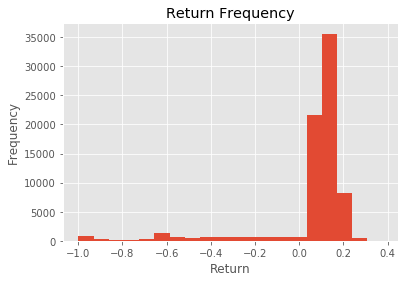

In [71]:
####Histogram of returns
plt.hist(df_filtered['irr'],bins=20) 
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Return Frequency')
plt.show()

    1. Lending returns are clearly not normally distributed and very long tailed skewed to the left. 
    2. That means extreme losses are frequent due to defaults. Again, pooling loans to spread the default risk out is key to a successful investment strategy.

##### Distribution of Pool of 100 Loans and 100 Trials

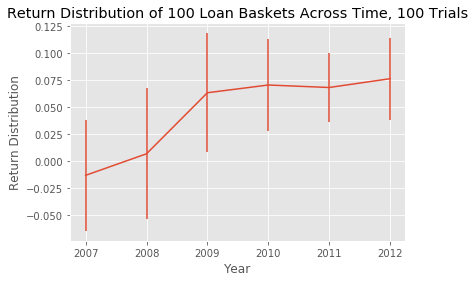

In [244]:
x = df_sharpe.index
y = [sublist[0] for sublist in df_sharpe.values]
yerr = [sublist[1]*2 for sublist in df_sharpe.values]
fig, ax = plt.subplots()
ax.errorbar(x, y,  yerr=yerr)
plt.xlabel('Year')
plt.ylabel('Return Distribution')
plt.title('Return Distribution of 100 Loan Baskets Across Time, 100 Trials')
plt.show()

This exercise of collecting 100 loan baskets tells us a few things
    1. Had we bought and held 100 loans, from 2009 - 2012, we would have almost surely made a positive return because we were effectively diversifying out the default rates. Result is even more favorable with bigger baskets.
    2. However, while we can diversify out the systematic risk of loan defaults, we can't diversfiy away systematic risk of a whole industry. To do that, we need to look at other asset classes that are negatively correlated to p2p lending market.

##### Overall Market IRR

In [73]:
weighted_avg

0.061408379614021645

##### Highest IRR Bucket by Year and Grade

In [74]:
df_group_irr.argmax()

(2012, 'G')

## Model for Portfolio Construction

### Linear Regression Model

In our EDA, we noticed that there are some characteristics of loans that gave us insights onto how profitable a loan might be. We will explore whether we can build a model that can help us capture this alpha. We will be fitting a linear regression for simplicity and interpretability. If our model proves successful we can dive deeper with a more rigorous model. Process is as follows.

    1. Split our data into training and test sets
    2. Train our model on a training set and make predictions on a test set
    3. We will compare a performance of two portfolios
        a. One built using top 1000 loans with highest return predictions
        b. A portfolio consisting of 1000 randomly selected loans
   
Our model's accuracy was low using traditional forecasting accuracy metrics such as RMSE. However, this doesn't discredit our model much because our asset class has very polarizing returns. Any model that yields a point estimate will have bad accuracy since real data will either overshoot(fully paid) or undershoot(default) our predictions. So, for our purposes, our goal is to create a basket of loans, that on average, will yield a higher return over a basket of randomly chosen loans



In [110]:
###splitting our data to test and train sets
msk = np.random.rand(len(df_filtered)) < 0.8
train = df_filtered[msk].copy()
test = df_filtered[~msk].copy()

In [111]:
train_sub = train[np.isfinite(train['annual_inc'])]

##### Feature Selection Using Nested Model Testing

We carefully vet our features using nested model testing. We start with a very simple model with just an interest rate, then as we add variables, we either accept it or reject it using F-statistics of two fits. If p<.05 we will keep the predictor.

In [112]:
y =  train_sub.irr
X = train_sub.int_rate
X1 = sm.add_constant(X)
est = sm.OLS(y, X1)
est1 = est.fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                    irr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     116.3
Date:                Wed, 27 Jun 2018   Prob (F-statistic):           4.25e-27
Time:                        20:45:06   Log-Likelihood:                 7021.5
No. Observations:               59921   AIC:                        -1.404e+04
Df Residuals:                   59919   BIC:                        -1.402e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0245      0.003      8.074      0.0

We see that the p-value for both variables are significant. We keep this model and test the next logical predictor.

In [113]:
###Fitting funded amount
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt']]

In [114]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    irr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     95.52
Date:                Wed, 27 Jun 2018   Prob (F-statistic):           3.82e-42
Time:                        20:45:11   Log-Likelihood:                 7058.8
No. Observations:               59921   AIC:                        -1.411e+04
Df Residuals:                   59918   BIC:                        -1.408e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0168      0.003      5.329      

In [115]:
anovaResults = anova_lm(est1, est2)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff          F        Pr(>F)
0   59919.0  2775.387679      0.0       NaN        NaN           NaN
1   59918.0  2771.938280      1.0  3.449398  74.561923  6.018088e-18


Our nested model test shows that including the funded amount predictor is significant. Also the variables are significant. We will move onto the next variable. We will repeat this process until we have a final model.

In [116]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc']]

Annual Income makes the cut.

In [118]:
X3 = sm.add_constant(X)
est = sm.OLS(y, X3)
est3= est.fit()
print(est3.summary())

In [119]:
anovaResults = anova_lm(est2, est3)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff        F        Pr(>F)
0   59918.0  2771.938280      0.0       NaN      NaN           NaN
1   59917.0  2768.043828      1.0  3.894452  84.2992  4.383805e-20


In [120]:
###Creating 0 or 1 dummy variables for loan grades
grade_predictors=pd.get_dummies(train_sub['grade'])
train_sub['a_flag'] = grade_predictors['A']
train_sub['b_flag'] = grade_predictors['B']
train_sub['c_flag'] = grade_predictors['C']
train_sub['d_flag'] = grade_predictors['D']
train_sub['e_flag'] = grade_predictors['E']
train_sub['f_flag'] = grade_predictors['F']
train_sub['g_flag'] = grade_predictors['G']

In [121]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','a_flag']]

In [123]:
X4 = sm.add_constant(X)
est = sm.OLS(y, X4)
est4= est.fit()

In [124]:
anovaResults = anova_lm(est3, est4)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff         F    Pr(>F)
0   59917.0  2768.043828      0.0       NaN       NaN       NaN
1   59916.0  2768.024184      1.0  0.019645  0.425227  0.514343


Nested Model Test Suggests including a flag for A grade is unnecessary. Also, the p-value is insignifcant.

B-Flag makes the cut.

In [125]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','b_flag']]

In [127]:
X5 = sm.add_constant(X)
est = sm.OLS(y, X5)
est5= est.fit()

In [128]:
anovaResults = anova_lm(est3, est5)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff          F        Pr(>F)
0   59917.0  2768.043828      0.0       NaN        NaN           NaN
1   59916.0  2766.815830      1.0  1.227998  26.592572  2.520049e-07


C-Flag does not make the cut.

In [129]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','b_flag','c_flag']]
X6 = sm.add_constant(X)
est = sm.OLS(y, X6)
est6= est.fit()

In [130]:
anovaResults = anova_lm(est5, est6)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff         F    Pr(>F)
0   59916.0  2766.815830      0.0       NaN       NaN       NaN
1   59915.0  2766.783922      1.0  0.031908  0.690982  0.405834


D-Flag does not make the cut.

In [131]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','b_flag','d_flag']]
X7 = sm.add_constant(X)
est = sm.OLS(y, X7)
est7= est.fit()
anovaResults = anova_lm(est5,est7)
print(anovaResults)

   df_resid         ssr  df_diff  ss_diff       F    Pr(>F)
0   59916.0  2766.81583      0.0      NaN     NaN       NaN
1   59915.0  2766.79118      1.0  0.02465  0.5338  0.465017


E-Flag does not make the cut.

In [135]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','b_flag','e_flag']]
X8 = sm.add_constant(X)
est = sm.OLS(y, X8)
est8= est.fit()
print(est8.summary())

In [137]:
anovaResults = anova_lm(est5,est8)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff         F    Pr(>F)
0   59916.0  2766.815830      0.0       NaN       NaN       NaN
1   59915.0  2766.639563      1.0  0.176267  3.817289  0.050731


F-Flag makes the cut.

In [147]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','b_flag','f_flag']]
X9 = sm.add_constant(X)
est = sm.OLS(y, X9)
est9= est.fit()
print(est9.summary())

In [144]:
anovaResults = anova_lm(est5,est9)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff          F        Pr(>F)
0   59916.0  2766.815830      0.0       NaN        NaN           NaN
1   59915.0  2765.281622      1.0  1.534208  33.241497  8.179329e-09


G-Flag makes the cut.

In [156]:
y =  train_sub.irr
X = train_sub[['int_rate','funded_amnt','annual_inc','b_flag','f_flag','g_flag']]
X10 = sm.add_constant(X)
est = sm.OLS(y, X10)
est10= est.fit()
print(est10.summary())

In [152]:
anovaResults = anova_lm(est9,est10)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff          F        Pr(>F)
0   59915.0  2765.281622      0.0       NaN        NaN           NaN
1   59914.0  2763.859319      1.0  1.422303  30.832195  2.825209e-08


We notice our constant is no longer significant. We will conduct a nested model testing on a model with the constant against the model without the constant. 

In [153]:
y =  train_sub.irr
X11 = train_sub[['int_rate','funded_amnt','annual_inc','b_flag','f_flag','g_flag']]
est = sm.OLS(y, X11)
est11= est.fit()
anovaResults = anova_lm(est11, est10)
print(anovaResults)

   df_resid          ssr  df_diff   ss_diff         F    Pr(>F)
0   59915.0  2763.886738      0.0       NaN       NaN       NaN
1   59914.0  2763.859319      1.0  0.027419  0.594379  0.440734


Nested model suggests that our y-intercept constant has little significance. We will go ahead without the constant

In [160]:
est11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    irr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     733.7
Date:                Wed, 27 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:53:30   Log-Likelihood:                 7145.9
No. Observations:               59921   AIC:                        -1.428e+04
Df Residuals:                   59915   BIC:                        -1.423e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
int_rate        0.0029      0.000     21.289      0.000       0.003       0.003
funded_amnt   8.07e-07   1.33e-07      6.059      0.000    5.46e-07    1.07e-06
annual_inc    1.36e-07   1.38e-08      9.823      0.000    1.09e-07    1.63e-07
b_flag          0.0089      0.002      4.999      0.000       0.005       0.012
f_flag         -0.0643      0.011     -6.018      0.000      -0.085      -0.043
g_flag         -0.0905      0.016     -5.635      0.000      -0.122      -0.059
==============================================================================
Omnibus:                    38290.759   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           327317.436
Skew:                          -3.136   Prob(JB):                         0.00
Kurtosis:                      12.579   Cond. No.                     1.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here is what our final model sugggets. These coefficient interpretations assume that all other variables are HELD CONSTANT.
    1. Every 1% increase in interest rate correlates to .29% increase in irr
    2. Every $10000 dollar increase in loan size correlates to .807% increase in irr
    3. Every $10000 dollar increase in average annual income correlates to .136% increase in irr
    4. B grades on average have .89% higher irr 
    5. F grades on average have 6.43% less irr 
    6. G Grades on average have 9.05% less irr
    7. All of our variables are significant. However, our R^2 isn't great. Our model doesn't explain much of the variability in the dataset. This is understandable since our model is a point estimate, but our data is polarized. Therefore, our residuals will be large.

Here are additional insights from our model
    1. We notice that the lower grades actually yield lower returns while our averages suggested otherwise. This is an effect so called the Simpson's Paradox. A directional influence of a predictor can change or decrease significantly, when explanatory effects of other significant predictors are taken away.
    2. Funded amount still stands as a significant predictor. Also, annual income proved to be significant as well. Potential explanation is that higher incomed individuals as well as indivduals who can command a higher loan amount are better financially positioned to meet their payments.
    3. It is likely that Lending Club's grade system is not efficient. Theoretically, if their grading system is perfect, there shouldn't be any explanatory effects we can get from variables that are factors into their grading system, i.e. annual income.
    4. We should be choosing high interest rate, high principal and high grade loans. 

In [161]:
test_sub = test[np.isfinite(test['annual_inc'])]

In [162]:
grade_predictors=pd.get_dummies(test_sub['grade'])
test_sub['a_flag'] = grade_predictors['A']
test_sub['b_flag'] = grade_predictors['B']
test_sub['c_flag'] = grade_predictors['C']
test_sub['d_flag'] = grade_predictors['D']
test_sub['e_flag'] = grade_predictors['E']
test_sub['f_flag'] = grade_predictors['F']
test_sub['g_flag'] = grade_predictors['G']

In [163]:
predictions = est11.predict(test_sub[['int_rate','funded_amnt','annual_inc','b_flag','f_flag','g_flag']])

In [164]:
RMSE = sum((predictions - test_sub['irr'])**2)**(1/2)
RMSE

26.050264183457809

For a model that forecasts IRRs which generally ranges from -1 to 1, this RMSE is quite bad. 
Also as shown in summary above, R^2 is very low at .07.

However, let's see our model performs when it comes to returns. We will take top 1000 loans from our model's prediction and compare that against a random sample of 1000 loans both from our test set.

In [165]:
test_sub['predictions'] = predictions
top1000= predictions.nlargest(n=10, keep='first')

Actual returns of top 1000 loans that our model predicted.

In [167]:
np.mean(test_sub[test_sub['predictions'].isin(top1000)]['irr'])

0.12818116544372413

Actual returns of 1000 randomly selected returns as well as its standard deviation after 100 trials.

In [168]:
###We collect 100 random samples of 1000 loans
collect_n_random_stats(test_sub,100,1000)

[0.072281513838226438, 0.006317205141019704]

We see a very significant 5.6% lift in returns. We are more confident with our model if it is able to generate higher returns at a lower basket size. It means we are effectively able to pick out the best performing loans and therefore subsequent selections are eating away at our alpha since we are forced to pick the next best loans.

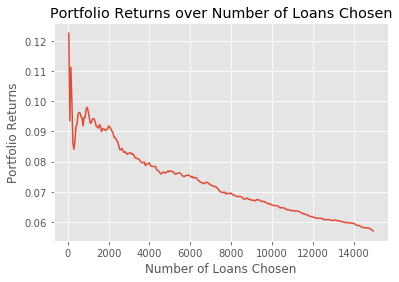

In [169]:
results = []
for size in np.arange(50,15000,50):
    topn= predictions.nlargest(n=size, keep='first')
    results.append(np.mean(test_sub[test_sub['predictions'].isin(topn)]['irr']))
x = np.arange(50,15000,50)
y = results
fig, ax = plt.subplots()
plt.xlabel('Number of Loans Chosen')
plt.ylabel('Portfolio Returns')
plt.title('Portfolio Returns over Number of Loans Chosen')
ax.errorbar(x, y)
plt.show()

We see a strong reversion to mean and lower returns as we increase the top number of loans we choose. This is a strong indication that our the model has good predictive powers and therefore, as we pick out the low hanging fruits, we start losing our alpha that our model generated. 

As an illustration, had we chosen all the loans in our test set, we would just have a simple average, and our model wouldn't have any voice as to which loans should be chosen.

However, we need to be careful of following things
    1. We are constructing our strategy with information we would not have had(we wouldn't know in 2012 how 2011 loans would have performed since they didn't fully mature yet). This is otherwise called a look-ahead bias. Again, a better method would be to explore a buy-hold-sell strategy or we should be using only data that would have been completely available at the time of purchase.
    2. We are quiet sure about how 1000 randomly chosen loans would have performed because we can sample that arbitrairly many times. However, we were only able to test our model once on a test set. We can try splitting our test set down into smaller chunks. However, this will definitely reduce our model's alpha since we aren't able to capture as many outliers per smaller sample.


##### Building Confidence on the Model Performance

To help us build confidence on our model and avoid the possibility that we "struck gold" by getting lucky with our selection, we will condudct some trials.

We will take our test set and collect 100 random samples of 1000 loans. From this sub-population of 1000 loans, we will find 100 best performing loans from our model and 100 randomly chosen models. We will collect this data 1000 times to see which method performs better.

In [176]:
def predict(df,size):
    predict_sub = est11.predict(df[['int_rate','funded_amnt','annual_inc','b_flag','f_flag','g_flag']])
    df['predictions'] = predict_sub
    top_size= predict_sub.nlargest(n=size, keep='first')
    return np.mean(df[df['predictions'].isin(top_size)]['irr'])

In [193]:
def collect_n_random_stats_compare(df,n,size,sub):
    returns_list = []
    models_list=[]
    for x in range(0,n):
        df_sub = df.sample(size, replace=False)
        df_out = df.sample(sub,replace=False)
        returns_list.append(irr_pool(df_out)) 
        models_list.append(predict(df_sub,sub))
    return [[returns_list], [models_list]]

In [229]:
compare_many = collect_n_random_stats_compare(test_sub,1000,1000,100)

In [230]:
np.mean(compare_many[0])

0.07139759294165722

In [231]:
np.mean(compare_many[1])

0.091499383085116903

In [232]:
np.std(compare_many[0])

0.020816348984374559

In [233]:
np.std(compare_many[1])

0.022011981807351536

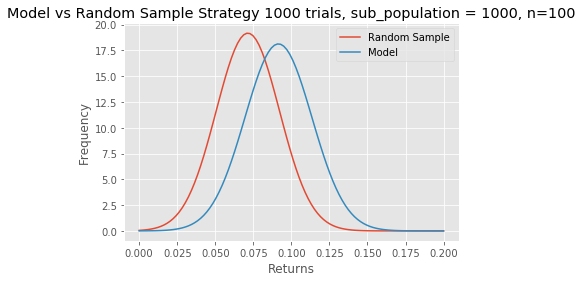

In [242]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

m1 = np.mean(compare_many[0])
std1 = np.std(compare_many[0])
m2 = np.mean(compare_many[1])
std2 = np.std(compare_many[1])

#Get point of intersect
result = solve(m1,m2,std1,std2)

#Get point on surface
x = np.linspace(0,.2,100)
plot1=plt.plot(x,norm.pdf(x,m1,std1))
plot2=plt.plot(x,norm.pdf(x,m2,std2))
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Model vs Random Sample Strategy 1000 trials, sub_population = 1000, n=100')
plt.legend(['Random Sample','Model'])
# integrate
area = norm.cdf(r,m2,std2) + (1.-norm.cdf(r,m1,std1))
plt.show()

We can see that our model still outperforms at mu = 9.27% vs 7.178%. Drop in our return is expected since we are working with a much smaller population, and thus it will be harder to pick out outperformers. We can expand our population so our model can have stronger alpha but we want to be careful and not sample too large % of the actual population.

## Modeling Summary

##### Key Insights from the Model

We fit a linear regression model for its simplicity and interpretability to help us pick out the best loans in our test set. Here are key insights from our model. 
    1. Our linear regression model was effective in picking out high performing loans in our test set. IRR of the 1000 loans from our model was 5% higher than IRR of 1000 randomly chosen loans. 
    
    2. Our accuracy(RMSE) and R2, however, were not good. This makes sense because our model is a point estimate but our asset class's return is often polarized(default or fully paid). 
    
    3. As we increase the number of loans we picked, we started losing our alpha. This is a positive indication that we  were able to pick out the low hanging fruits effectively, and as we increase our selection size, we were forced to pick the next best loan.
    
    4. Our model suggests that low grade loans actually yield lower return than high grade loans. This is different than what the simple averages showed us. This is an example of a Simpson's Paradox.
    
    5. To gain confidence and avoid the possibility that we got lucky with our model, we conduct trials. It basically shows that our model still performed better than random selection.
    
    6. There may be a look ahead bias in our dataset since we are picking out loans using information(performance over its full life) that we would not have had otherwise.
    
    7. Therefore, I recommend exploring a buy-hold-sell strategy using the note trading platform. This way we can model a shorter term strategy that can leverage more recent data.

##### Model Output

In [170]:
est11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    irr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     733.7
Date:                Wed, 27 Jun 2018   Prob (F-statistic):               0.00
Time:                        21:12:49   Log-Likelihood:                 7145.9
No. Observations:               59921   AIC:                        -1.428e+04
Df Residuals:                   59915   BIC:                        -1.423e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
int_rate        0.0029      0.000     21.289      0.000       0.003       0.003
funded_amnt   8.07e-07   1.33e-07      6.059      0.000    5.46e-07    1.07e-06
annual_inc    1.36e-07   1.38e-08      9.823      0.000    1.09e-07    1.63e-07
b_flag          0.0089      0.002      4.999      0.000       0.005       0.012
f_flag         -0.0643      0.011     -6.018      0.000      -0.085      -0.043
g_flag         -0.0905      0.016     -5.635      0.000      -0.122      -0.059
==============================================================================
Omnibus:                    38290.759   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           327317.436
Skew:                          -3.136   Prob(JB):                         0.00
Kurtosis:                      12.579   Cond. No.                     1.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model output confirms a lot of our initial assumptions on how loan size, income and interest rate might help us predict returns. On the contrary, it also tells us that lower grade loans actually DECREASE our returns unlike what we saw with averages earlier. This is an example of a Simpson's Paradox where your predictors that initially seemed significant changes direction or loses its significance as we fit other truly predictive variables.

Higher int_rate, funded_amnt, annual income and B grade loans are positively correlated with higher returns. F grade and G Grade loans are negatively correlated with higher returns.

###### Model Performance 

Actual returns of top 1000 loans that our model predicted.

In [172]:
np.mean(test_sub[test_sub['predictions'].isin(top1000)]['irr'])

0.12818116544372413

Actual returns of top randomly chosen 1000 loans, and its standard deviation over 100 trials.

In [173]:
collect_n_random_stats(test_sub,100,1000)

[0.071735084502116561, 0.006717519240826731]

We can see that our model outperformed vs the random sampling method as large as 5.7%.

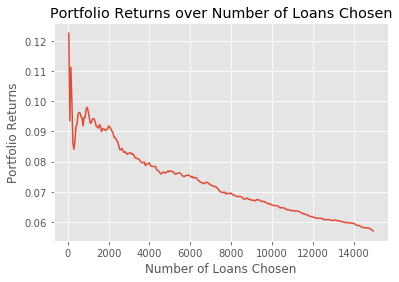

In [174]:
results = []
for size in np.arange(50,15000,50):
    topn= predictions.nlargest(n=size, keep='first')
    results.append(np.mean(test_sub[test_sub['predictions'].isin(topn)]['irr']))
x = np.arange(50,15000,50)
y = results
fig, ax = plt.subplots()
plt.xlabel('Number of Loans Chosen')
plt.ylabel('Portfolio Returns')
plt.title('Portfolio Returns over Number of Loans Chosen')
ax.errorbar(x, y)
plt.show()

As we increase our number of loans, we see that our returns revert to mean. This is a strong indication that we are choosing the right loans and we are identifying the low hanging fruits effectively. As an illustration, if we take all the loans, we will just have a simple average of all the loans and our model would not have told us anything.

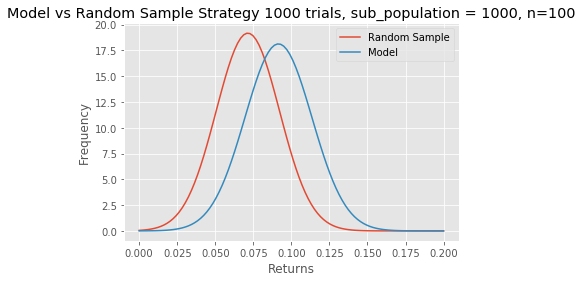

In [243]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

m1 = np.mean(compare_many[0])
std1 = np.std(compare_many[0])
m2 = np.mean(compare_many[1])
std2 = np.std(compare_many[1])

#Get point of intersect
result = solve(m1,m2,std1,std2)

#Get point on surface
x = np.linspace(0,.2,100)
plot1=plt.plot(x,norm.pdf(x,m1,std1))
plot2=plt.plot(x,norm.pdf(x,m2,std2))
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Model vs Random Sample Strategy 1000 trials, sub_population = 1000, n=100')
plt.legend(['Random Sample','Model'])
# integrate
area = norm.cdf(r,m2,std2) + (1.-norm.cdf(r,m1,std1))
plt.show()

We can see that even with lots of trials, our model outperforms the random sample strategy. We can gain more confidence by increasing the sub population (more number of potential outperformers). However, we lack the proper data size and we want to make sure we don't sample too large of a  % of the actual population. 